In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings





In [43]:
data = pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')

In [44]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

In [45]:
# Remove commas and convert Supply to float
data['Supply'] = data['Supply'].str.replace(',', '').astype(float)

# Create target variable (y) and features (X)
target = 'Supply'
features = ['72 Day Temperature', '72 Day Precipitation']
y = data[target]
X = data[features]

In [46]:
# Step 2: Train-test split for time series
train_size = int(0.8 * len(y))
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

In [47]:
# Step 3: Fit the ETS model
ets_model = ExponentialSmoothing(y_train, trend=None, seasonal='add', seasonal_periods=72).fit()

# Make ETS forecasts and calculate residuals
ets_forecast = ets_model.forecast(len(y_test))
residuals_train = y_train - ets_model.fittedvalues  # Residuals from training


In [53]:
# Step 4: Standardize the features for LightGBM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Drop NaN values from initial residuals for training
residuals_train = residuals_train.dropna()
X_train_scaled = X_train_scaled[-len(residuals_train):]  # Match index with residuals

# Step 5: Train LightGBM on residuals
lgb_train_data = lgb.Dataset(X_train_scaled, label=residuals_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'verbose': -1
}
lgb_model = lgb.train(params, lgb_train_data, num_boost_round=100)


In [49]:
print(X_train.var())



72 Day Temperature       6.707386
72 Day Precipitation    20.991621
dtype: float64


In [50]:
# Step 6: Make predictions with LightGBM on test data
lgb_residuals_pred = lgb_model.predict(X_test_scaled)

# Step 7: Combine ETS forecasts and LightGBM residual predictions for final prediction
final_predictions = ets_forecast + lgb_residuals_pred

# Step 8: Evaluate RMSE of the combined model
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"RMSE of Improved Hybrid Model: {rmse}")


RMSE of Improved Hybrid Model: 9264528.706309145


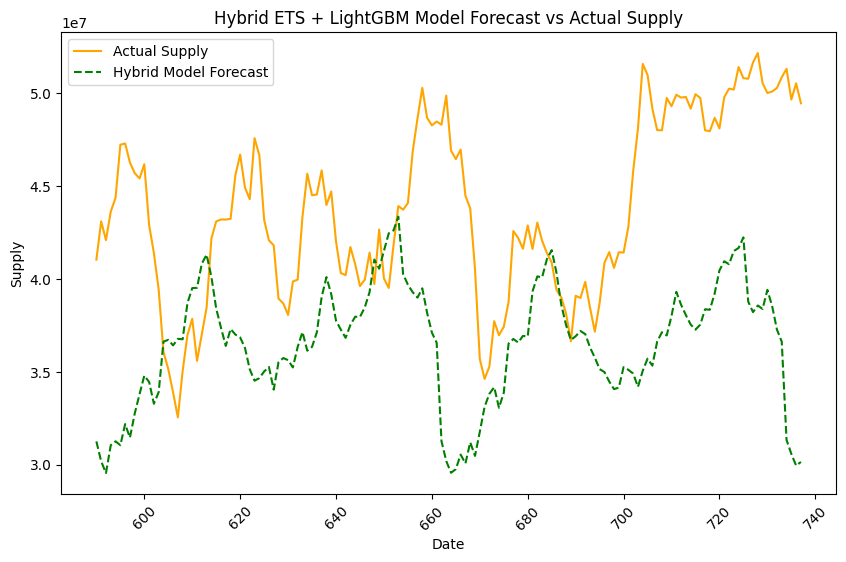

In [51]:
# Plotting results
plt.figure(figsize=(10, 6))
# plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual Supply', color='orange')
plt.plot(y_test.index, final_predictions, label='Hybrid Model Forecast', linestyle='--', color='green')
plt.legend()
plt.title('Hybrid ETS + LightGBM Model Forecast vs Actual Supply')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.xticks(rotation=45)
plt.show()